In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob

import os
# 显示工作路径
print(os.getcwd())

# 设置工作路径
os.chdir('/Users/ss/Documents/Self_modulate_VisualCortex')

# 显示当前路径
print(os.getcwd())

/Users/ss/Documents/Self_modulate_VisualCortex/Scripts/2_Behav_Data_analysis
/Users/ss/Documents/Self_modulate_VisualCortex


In [2]:
# 使得中文字体可以显示
# 设置字体为Arial Unicode MS
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS']
plt.rcParams['axes.unicode_minus'] = False

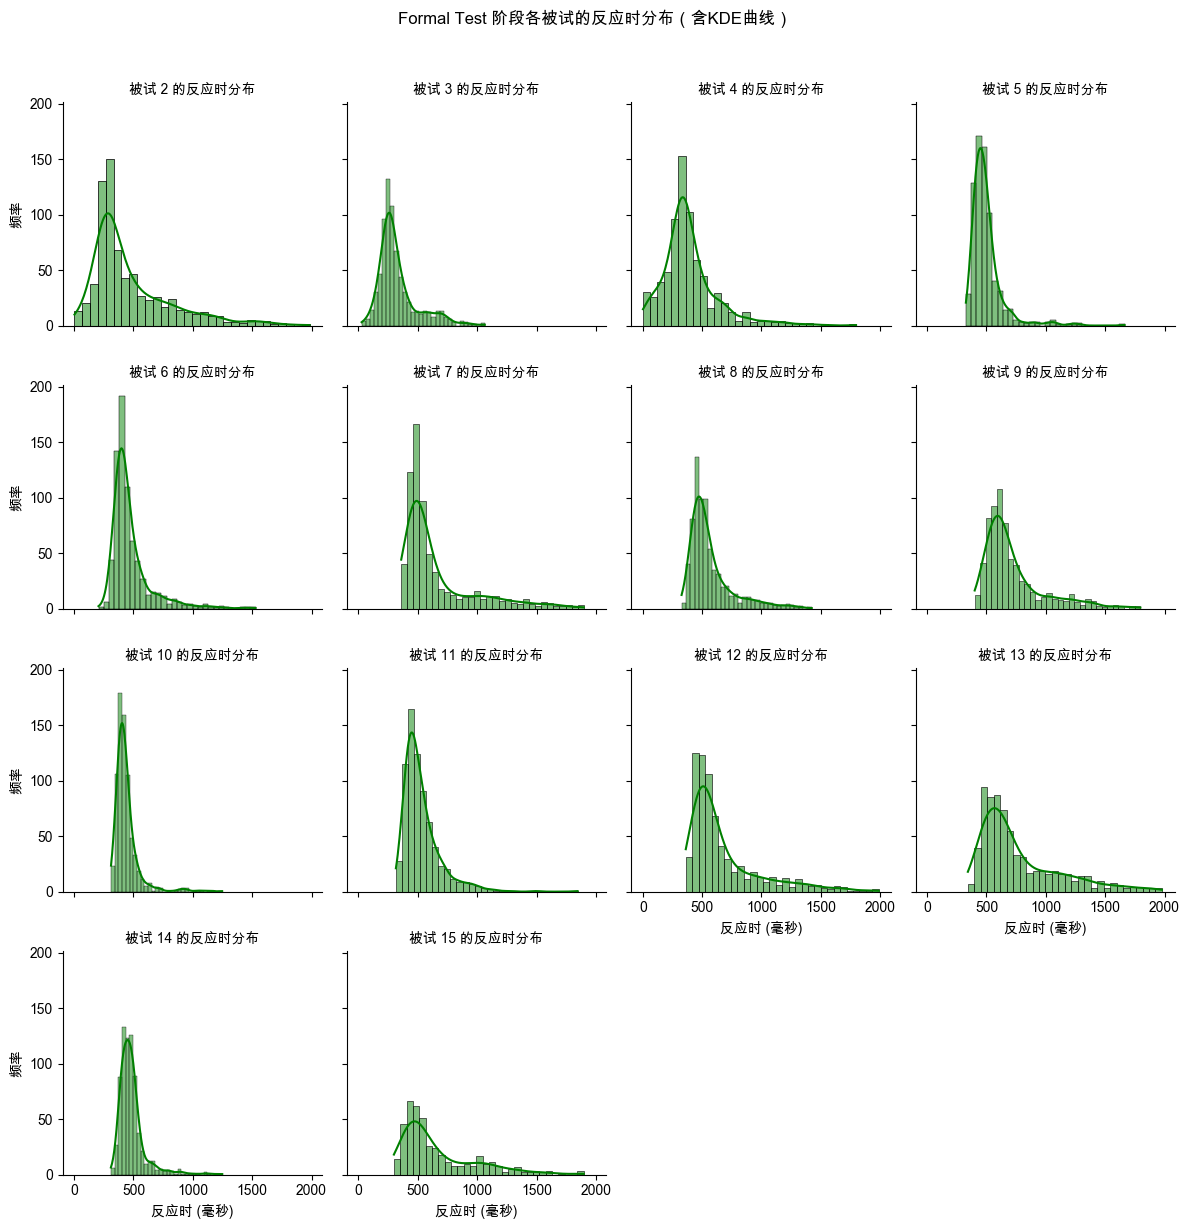

In [4]:
# 绘制预实验的反应时分布

# 读取所有CSV文件并合并
file_paths = glob.glob("Output/2_Exp_behav_data/Exp1_task1_0**.csv")  # 匹配文件路径
data_list = []

for file_path in file_paths:
    # 提取编号部分
    subject_id = int(file_path.split('_')[-1].split('.')[0])  # 使用最后的 '_00*.csv' 提取编号
    df = pd.read_csv(file_path)
    df['subject'] = subject_id  # 添加被试编号
    data_list.append(df)

data = pd.concat(data_list, ignore_index=True)

# 过滤出 Formal Test 阶段数据
rt_formal_test = data[data['stage'] == 'formal_test']

# 使用 FacetGrid 绘制各被试反应时分布，带KDE曲线
g = sns.FacetGrid(rt_formal_test, col='subject', col_wrap=4, height=3)
g.map(sns.histplot, 'rt', bins=30, color='green', kde=True)
g.set_axis_labels('反应时 (毫秒)', '频率')
g.set_titles('被试 {col_name} 的反应时分布')
plt.suptitle('Formal Test 阶段各被试的反应时分布（含KDE曲线）', y=1.02)
plt.tight_layout()
plt.show()


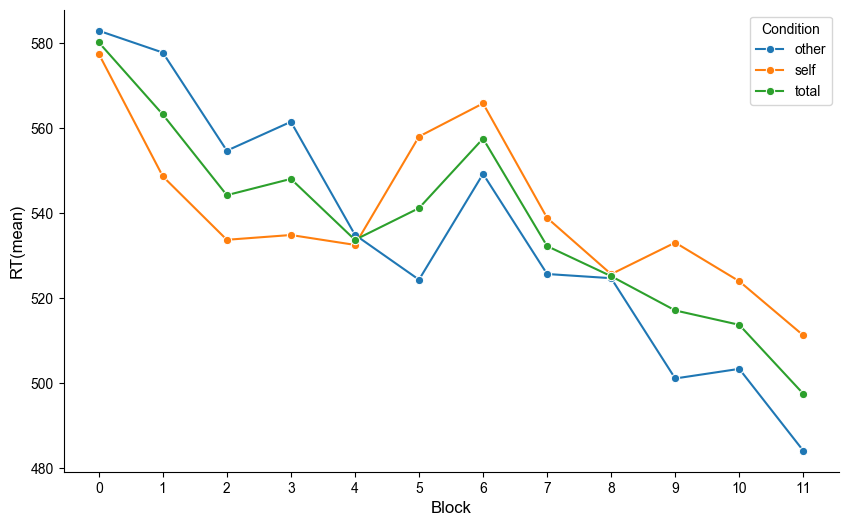

In [5]:
for file_path in file_paths:
    df = pd.read_csv(file_path)
    data_list.append(df)

# 合并所有数据
df = pd.concat(data_list, ignore_index=True)

# 筛选 formal_test 阶段的数据
df_formal_test = df[(df["stage"] == "formal_test") & (df["correct"] == 1)]

# 计算不同 block 和 condition 下的 RT 均值（跨所有被试）
rt_data = df_formal_test.groupby(["block", "condition"])["rt"].mean().reset_index()

# 计算每个 block 的总 RT 均值
total_rt_data = df_formal_test.groupby("block")["rt"].mean().reset_index()
total_rt_data["condition"] = "total"  # 添加一个 condition 列用于区分

# 转换 block 类型并排序
rt_data["block"] = rt_data["block"].astype(int)
total_rt_data["block"] = total_rt_data["block"].astype(int)
rt_data = rt_data.sort_values("block")
total_rt_data = total_rt_data.sort_values("block")

# 合并 RT 数据
combined_rt_data = pd.concat([rt_data, total_rt_data])

# 绘图
plt.figure(figsize=(10, 6))
sns.lineplot(data=combined_rt_data, x="block", y="rt", hue="condition", marker="o")

# 设置图表标题和标签
plt.xlabel("Block", fontsize=12)
plt.ylabel("RT(mean)", fontsize=12)
plt.xticks(range(min(combined_rt_data["block"]), max(combined_rt_data["block"]) + 1))
plt.legend(title="Condition")
plt.grid(False)
sns.despine()

# 显示图表
plt.show()

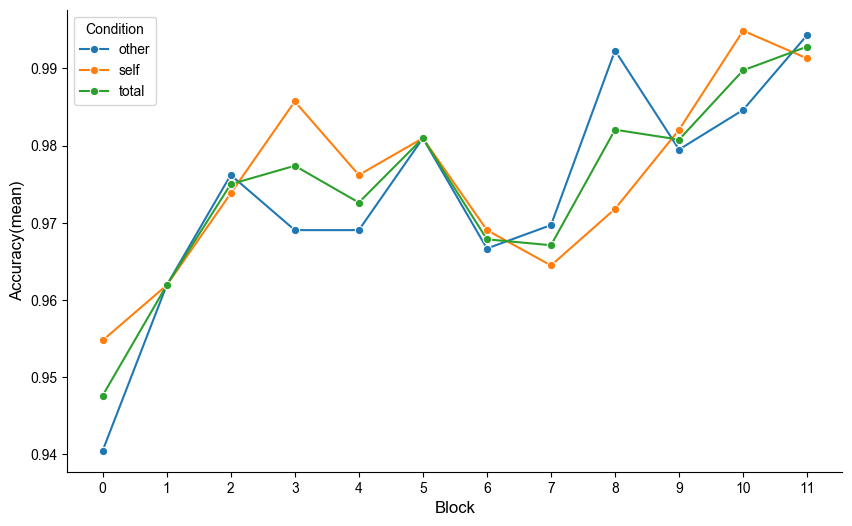

In [6]:
# 筛选 formal_test 阶段的数据
df_formal_test = df[df["stage"] == "formal_test"]

# 计算不同 block 和 condition 下的正确率均值（跨所有被试）
accuracy_data = df_formal_test.groupby(["block", "condition"])["correct"].mean().reset_index()

# 计算每个 block 的总正确率均值
total_accuracy_data = df_formal_test.groupby("block")["correct"].mean().reset_index()
total_accuracy_data["condition"] = "total"  # 添加一个 condition 列用于区分

# 转换 block 类型并排序
accuracy_data["block"] = accuracy_data["block"].astype(int)
total_accuracy_data["block"] = total_accuracy_data["block"].astype(int)
accuracy_data = accuracy_data.sort_values("block")
total_accuracy_data = total_accuracy_data.sort_values("block")

# 合并正确率数据
combined_accuracy_data = pd.concat([accuracy_data, total_accuracy_data])

# 绘制正确率折线图
plt.figure(figsize=(10, 6))
sns.lineplot(data=combined_accuracy_data, x="block", y="correct", hue="condition", marker="o")
plt.xlabel("Block", fontsize=12)
plt.ylabel("Accuracy(mean)", fontsize=12)
plt.xticks(range(min(combined_accuracy_data["block"]), max(combined_accuracy_data["block"]) + 1))
plt.legend(title="Condition")
plt.grid(False)
sns.despine()  # 去除上方和右侧的边框
plt.show()

In [7]:
import glob
import pandas as pd
import numpy as np
from scipy.stats import ttest_rel
import seaborn as sns
import matplotlib.pyplot as plt

# 1. 数据读取与预处理
# --------------------------------------------------
# 读取所有CSV文件
file_paths = glob.glob("Output/2_Exp_behav_data/Exp1_task1_0*.csv")
data_list = []

for file_path in file_paths:
    try:
        # 提取被试编号（假设文件名格式为..._001.csv）
        subject_id = int(file_path.split('_')[-1].split('.')[0])
        df = pd.read_csv(file_path)
        df['subject'] = subject_id
        data_list.append(df)
    except Exception as e:
        print(f"Error processing {file_path}: {str(e)}")

# 合并数据
raw_data = pd.concat(data_list, ignore_index=True)

In [8]:
# 2. 数据筛选与清洗
# --------------------------------------------------
# 筛选formal_test阶段数据
formal_data = raw_data[(raw_data['stage'] == 'formal_test') & 
                       (raw_data['block'].between(9, 11))].copy()

# formal_data = raw_data[(raw_data['stage'] == 'formal_test')].copy()

# 检查数据完整性
print("\n数据基本信息：")
print(f"总试次数：{len(formal_data)}")
print(f"唯一被试数：{formal_data['subject'].nunique()}")
print(f"条件分布：\n{formal_data['condition'].value_counts()}")


数据基本信息：
总试次数：2256
唯一被试数：13
条件分布：
condition
other    1132
self     1124
Name: count, dtype: int64


In [9]:
# 3. 数据准备（使用数据透视表确保配对）
# --------------------------------------------------
# 正确率透视表（自动处理缺失值）
accuracy_pivot = formal_data.pivot_table(
    index='subject',
    columns='condition',
    values='correct',
    aggfunc='mean'
)

In [10]:
# 反应时透视表（仅正确试次）
rt_pivot = formal_data[formal_data['correct'] == 1].pivot_table(
    index='subject',
    columns='condition',
    values='rt',
    aggfunc='mean'
)

# 4. 数据完整性检查
# --------------------------------------------------
print("\n=== 数据完整性报告 ===")
print(f"原始被试数：{formal_data['subject'].nunique()}")
print(f"有效正确率被试数：{accuracy_pivot.dropna().shape[0]}")
print(f"有效反应时被试数：{rt_pivot.dropna().shape[0]}")

# 检查缺失被试
missing_subjects = rt_pivot[rt_pivot.isnull().any(axis=1)].index.tolist()
if missing_subjects:
    print(f"\n警告：以下被试在某个条件中无有效反应时数据：{missing_subjects}")



=== 数据完整性报告 ===
原始被试数：13
有效正确率被试数：13
有效反应时被试数：13


In [11]:
# 5. 执行配对样本t检验
# --------------------------------------------------
# 移除存在缺失值的被试（确保配对）
clean_acc = accuracy_pivot.dropna()
clean_rt = rt_pivot.dropna()

# 正确率t检验
t_acc, p_acc = ttest_rel(clean_acc['self'], clean_acc['other'])

# 反应时t检验
t_rt, p_rt = ttest_rel(clean_rt['self'], clean_rt['other'])

In [12]:
from scipy.stats import shapiro
print("正确率差值正态性检验:", shapiro(clean_acc['self'] - clean_acc['other']))
print("反应时差值正态性检验:", shapiro(clean_rt['self'] - clean_rt['other']))

正确率差值正态性检验: ShapiroResult(statistic=np.float64(0.9326642213117938), pvalue=np.float64(0.3691128196047011))
反应时差值正态性检验: ShapiroResult(statistic=np.float64(0.9370149861702084), pvalue=np.float64(0.41942914762029265))


In [13]:
# 6. 计算效应量（Cohen's d）
# --------------------------------------------------
def cohens_d(paired_data):
    """计算配对样本的Cohen's d"""
    diff = paired_data['self'] - paired_data['other']
    return diff.mean() / diff.std()

d_acc = cohens_d(clean_acc)
d_rt = cohens_d(clean_rt)

# 7. 结果输出
# --------------------------------------------------
print("\n=== 统计分析结果 ===")
print(f"正确率配对t检验：t({len(clean_acc)-1}) = {t_acc:.3f}, p = {p_acc:.3f}, d = {d_acc:.3f}")
print(f"反应时配对t检验：t({len(clean_rt)-1}) = {t_rt:.3f}, p = {p_rt:.3f}, d = {d_rt:.3f}")


=== 统计分析结果 ===
正确率配对t检验：t(12) = 0.567, p = 0.581, d = 0.157
反应时配对t检验：t(12) = 2.967, p = 0.012, d = 0.823


/var/folders/yk/78rqxlxn4pz_rsb5_31xvh340000gn/T/ipykernel_3338/1902038200.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=clean_acc.melt(var_name='condition', value_name='accuracy'),
/var/folders/yk/78rqxlxn4pz_rsb5_31xvh340000gn/T/ipykernel_3338/1902038200.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=clean_rt.melt(var_name='condition', value_name='RT'),


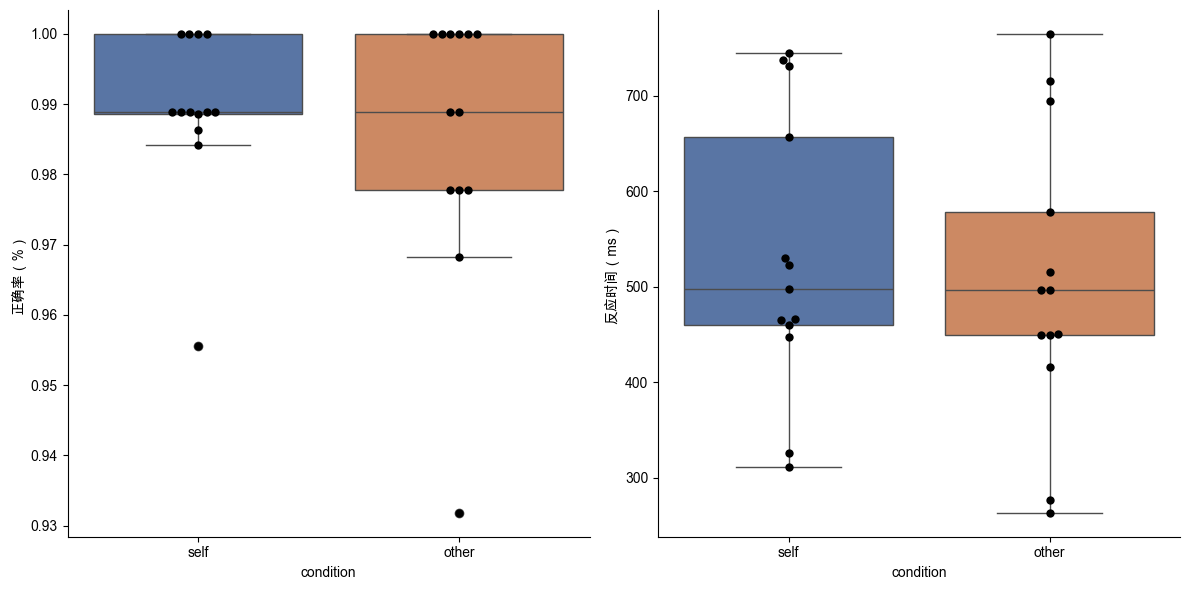

In [14]:
# 8. 数据可视化
# --------------------------------------------------
plt.figure(figsize=(12, 6))

# 正确率对比
plt.subplot(1, 2, 1)
sns.boxplot(data=clean_acc.melt(var_name='condition', value_name='accuracy'), 
            x='condition', y='accuracy', 
            palette={'self': '#4C72B0', 'other': '#DD8452'}, 
            order=['self', 'other'])  # 设置顺序
sns.swarmplot(data=clean_acc.melt(var_name='condition', value_name='accuracy'),
              x='condition', y='accuracy', color='black', size=6, 
              order=['self', 'other'])  # 设置顺序
# plt.title("正确率对比\n(配对样本)")
plt.ylabel("正确率（%）")

# 反应时对比
plt.subplot(1, 2, 2)
sns.boxplot(data=clean_rt.melt(var_name='condition', value_name='RT'), 
            x='condition', y='RT', 
            palette={'self': '#4C72B0', 'other': '#DD8452'},
            order=['self', 'other'])  # 设置顺序
sns.swarmplot(data=clean_rt.melt(var_name='condition', value_name='RT'),
              x='condition', y='RT', color='black', size=6, 
              order=['self', 'other'])  # 设置顺序
# plt.title("反应时对比（毫秒）\n(配对样本)")
plt.ylabel("反应时间（ms）")
sns.despine()
plt.tight_layout()
plt.show()


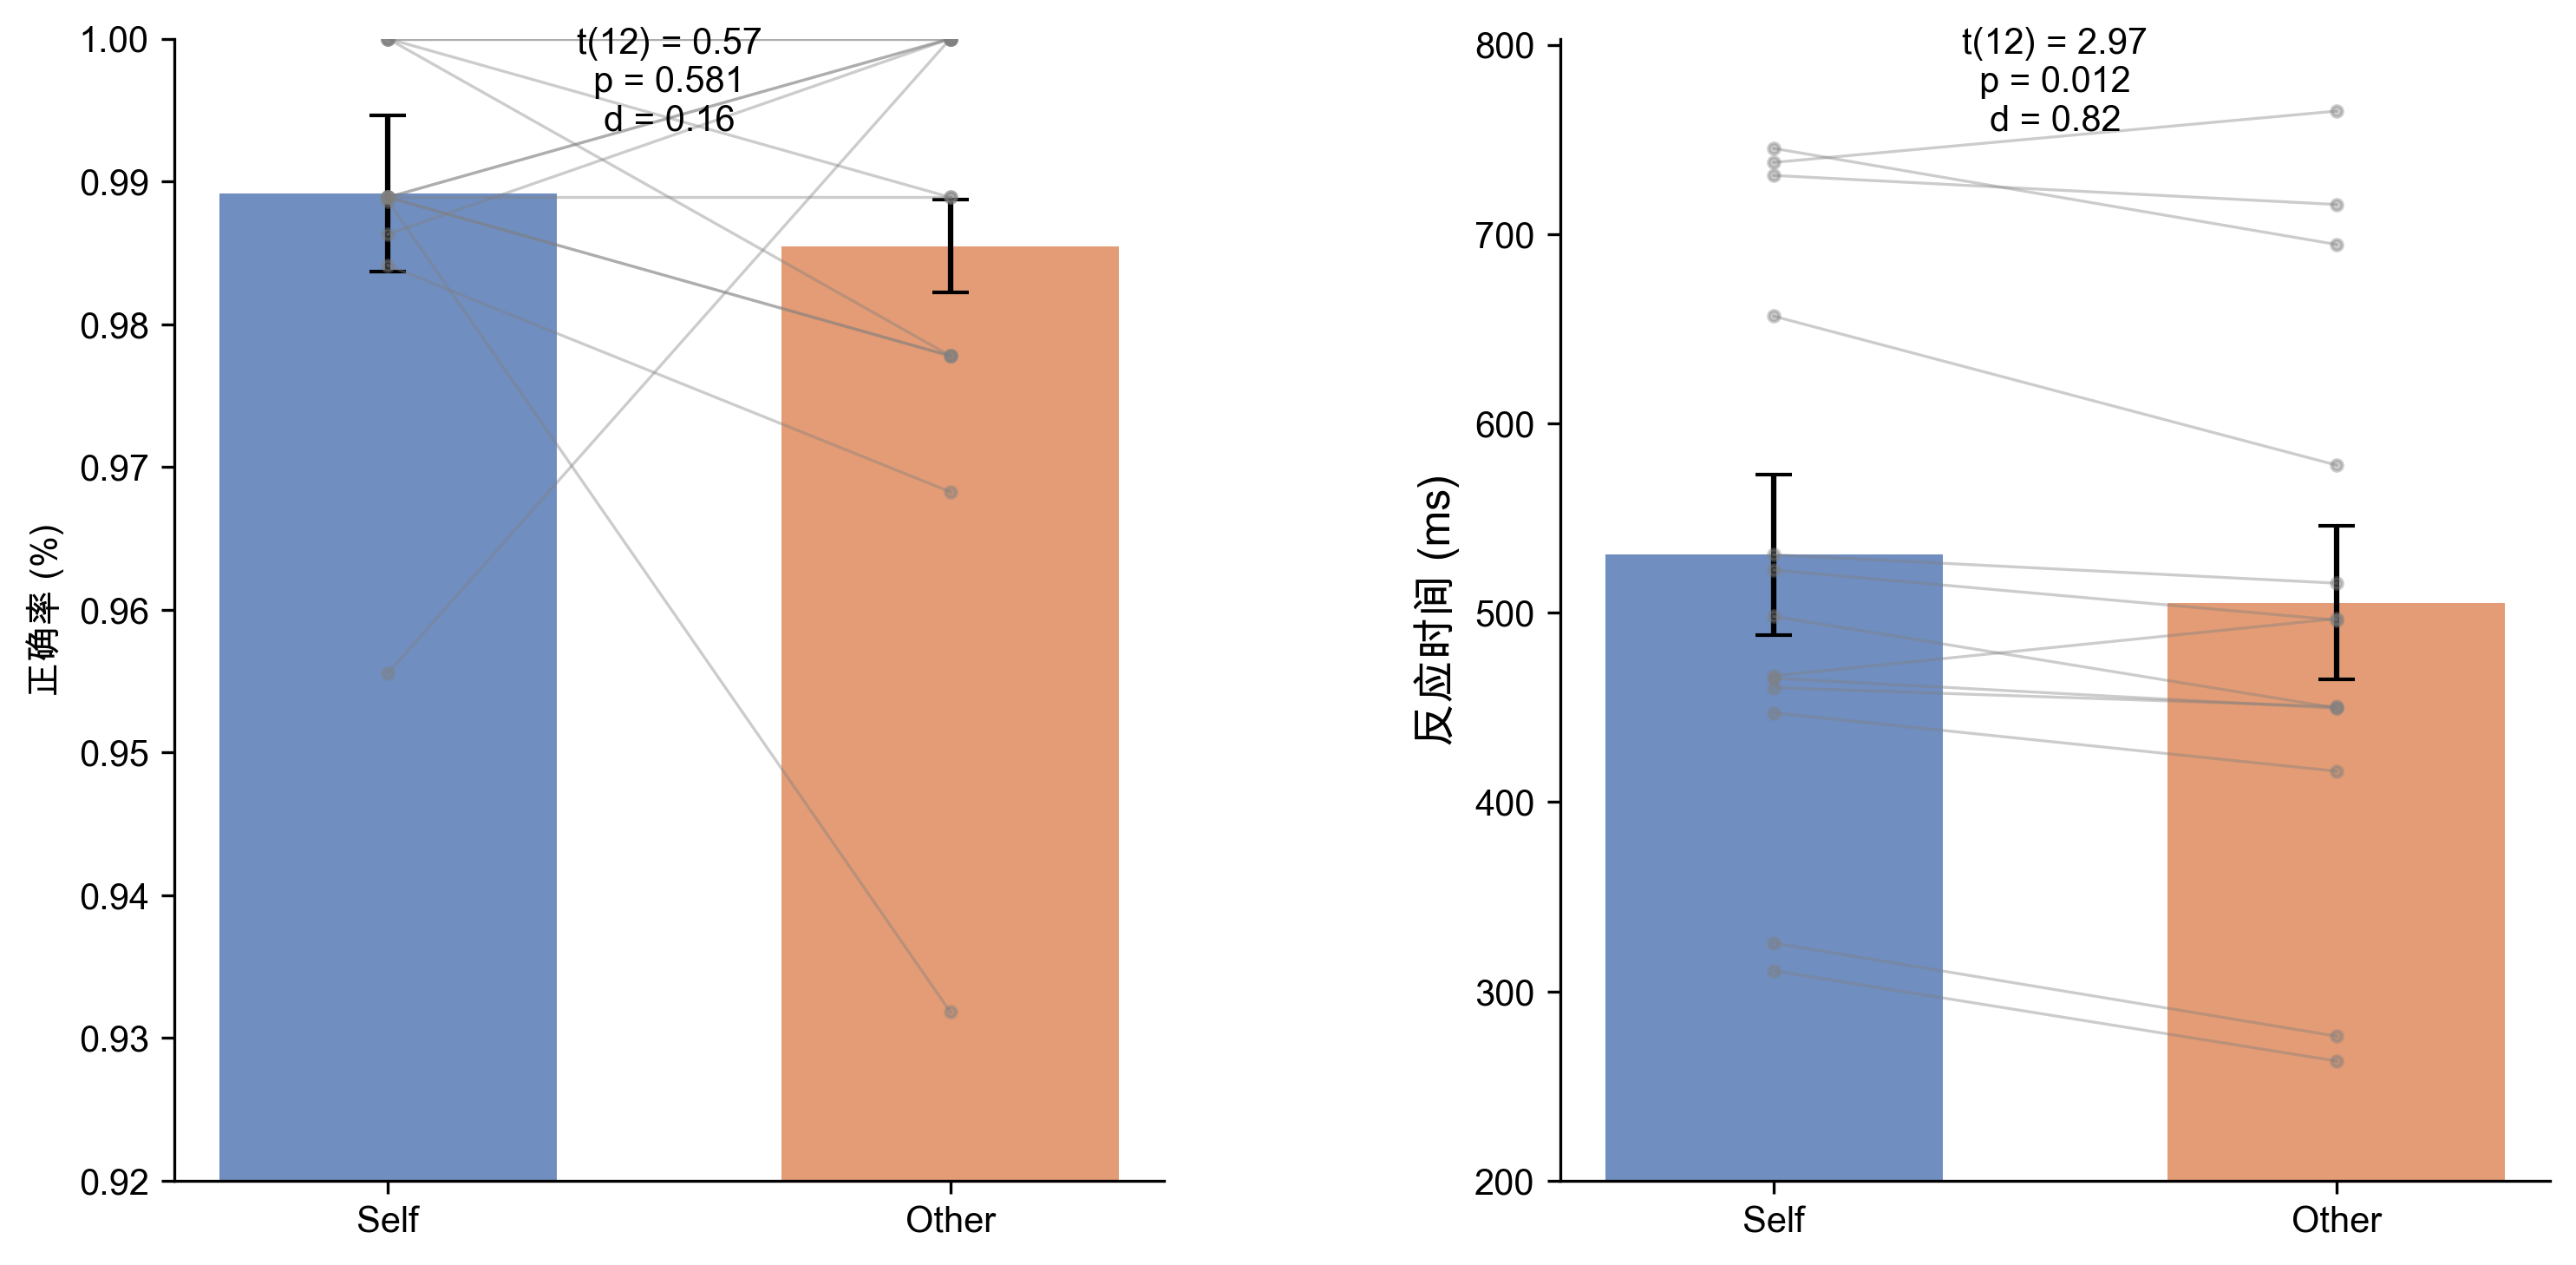

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 准备数据（使用前一个代码中的 clean_acc 和 clean_rt）
# --------------------------------------------------
# 计算均值和标准误
acc_mean = clean_acc.mean()
acc_sem = clean_acc.sem()  # 标准误

rt_mean = clean_rt.mean()
rt_sem = clean_rt.sem()


# 创建画布
plt.figure(figsize=(10, 5), dpi=300)

# 正确率柱状图
# --------------------------------------------------
plt.subplot(1, 2, 1)
bars = plt.bar(['Self', 'Other'], 
               [acc_mean['self'], acc_mean['other']],
              yerr=acc_sem,  # 添加误差线（标准误）
              capsize=5,     # 误差线端帽长度
              color=['#4C72B0', '#DD8452'],
              alpha=0.8,
              width=0.6)

# 添加个体差异连线（关键配对信息）
for idx, subj in enumerate(clean_acc.index):
    plt.plot(['Self', 'Other'], 
             [clean_acc.loc[subj, 'self'], clean_acc.loc[subj, 'other']],
             color='gray', 
             alpha=0.4,
             lw=0.8,
             marker='o',
             markersize=3)

# 标注统计结果
plt.text(0.5, 0.92, 
         f"t({len(clean_acc)-1}) = {t_acc:.2f}\np = {p_acc:.3f}\nd = {d_acc:.2f}",
         ha='center',
         fontsize=10,
         transform=plt.gca().transAxes)

plt.ylabel("正确率 (%)")
plt.ylim(0.92, 1.0)  # 根据实际数据调整
plt.xticks(fontsize=10)  # 调整 x 轴刻度字体大小
plt.yticks(fontsize=10)  # 调整 y 轴刻度字体大小


# 反应时柱状图
# --------------------------------------------------
plt.subplot(1, 2, 2)
plt.bar(['Self', 'Other'], 
        [rt_mean['self'], rt_mean['other']], 
        yerr=rt_sem,
        capsize=5,
        color=['#4C72B0', '#DD8452'],
        alpha=0.8,
        width=0.6)

# 添加个体连线
for idx, subj in enumerate(clean_rt.index):
    plt.plot(['Self', 'Other'], 
             [clean_rt.loc[subj, 'self'], clean_rt.loc[subj, 'other']],
             color='gray', 
             alpha=0.4,
             lw=0.8,
             marker='o',
             markersize=3)

# 标注统计结果
plt.text(0.5, 0.92, 
         f"t({len(clean_rt)-1}) = {t_rt:.2f}\np = {p_rt:.3f}\nd = {d_rt:.2f}",
         ha='center',
         fontsize=10,
         transform=plt.gca().transAxes)

plt.ylabel("反应时间 (ms)", fontsize=12)
plt.ylim(200, None)  # 修改 y 轴范围，None 表示不限制最大值
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.tight_layout()
plt.subplots_adjust(wspace=0.4) 

sns.despine()
plt.show()

In [16]:
clean_acc

condition,other,self
subject,,
2,0.977778,0.988889
3,1.000000,0.988889
4,0.988889,1.000000
5,1.000000,1.000000
6,1.000000,0.955556
7,1.000000,0.986301
8,0.977778,0.988889
9,0.968254,0.984127
10,1.000000,0.988889


In [18]:
clean_rt

condition,other,self
subject,,
2,450.423613,460.410526
3,263.245210,310.851142
4,276.365870,325.494913
5,449.723942,498.053951
6,496.837381,466.686313
7,578.008800,656.618256
8,515.614799,530.641829
9,764.943002,737.843481
10,416.325386,447.076355


In [76]:
print(f"rt_mean: {rt_mean}")
print(f"rt_sem: {rt_sem}")


rt_mean: condition
other    505.179280
self     530.608513
dtype: float64
rt_sem: condition
other    42.451574
self     40.570435
dtype: float64


In [77]:
print(acc_mean)
print(acc_sem)


condition
other    0.985476
self     0.989159
dtype: float64
condition
other    0.005455
self     0.003236
dtype: float64


### 方差分析

In [25]:
def process_subject(file_path):
    # 读取CSV文件
    df = pd.read_csv(file_path)
    subject_id = df['subject_id'].iloc[0]  # 获取被试ID（假设每个文件中subject_id一致）
    
    # 筛选"formal_test"阶段的数据
    formal_test = df[df['stage'] == 'formal_test']
    
    # 对于RT：只保留正确试次，计算每个block和condition的平均RT
    correct_trials = formal_test[formal_test['correct'] == 1]
    rt_mean = correct_trials.groupby(['block', 'condition'])['rt'].mean().reset_index()
    rt_mean['subject_id'] = subject_id
    
    # 对于accuracy：计算每个block和condition的正确率
    accuracy = formal_test.groupby(['block', 'condition'])['correct'].mean().reset_index()
    accuracy = accuracy.rename(columns={'correct': 'accuracy'})  # 重命名为accuracy
    accuracy['subject_id'] = subject_id
    
    return rt_mean, accuracy

In [26]:
# 获取所有CSV文件路径
csv_files = glob.glob('Output/2_Exp_behav_data/*.csv')  # 调整路径为你的实际文件夹

# 初始化列表存储所有被试的结果
all_rt = []
all_accuracy = []

# 循环处理每个CSV文件
for file in csv_files:
    rt, acc = process_subject(file)
    all_rt.append(rt)
    all_accuracy.append(acc)

# 合并所有数据
rt_data = pd.concat(all_rt, ignore_index=True)
accuracy_data = pd.concat(all_accuracy, ignore_index=True)

# 检查数据（可选）
print("RT Data:")
print(rt_data.head())
print("\nAccuracy Data:")
print(accuracy_data.head())

RT Data:
   block condition          rt  subject_id
0    0.0     other  538.697128           8
1    0.0      self  611.746600           8
2    1.0     other  547.463779           8
3    1.0      self  626.366213           8
4    2.0     other  575.212880           8

Accuracy Data:
   block condition  accuracy  subject_id
0    0.0     other  0.966667           8
1    0.0      self  0.966667           8
2    1.0     other  0.966667           8
3    1.0      self  1.000000           8
4    2.0     other  1.000000           8


In [27]:
# 保存处理好的数据为CSV文件
output_dir = 'Output/3_Exp_processed_data/'  # 指定保存文件的目录
os.makedirs(output_dir, exist_ok=True)  # 如果目录不存在，则创建

# 保存RT数据
rt_data.to_csv(os.path.join(output_dir, 'rt_data.csv'), index=False)
print(f"RT数据已保存到 {os.path.join(output_dir, 'rt_data.csv')}")

# 保存Accuracy数据
accuracy_data.to_csv(os.path.join(output_dir, 'accuracy_data.csv'), index=False)
print(f"Accuracy数据已保存到 {os.path.join(output_dir, 'accuracy_data.csv')}")

RT数据已保存到 Output/3_Exp_processed_data/rt_data.csv
Accuracy数据已保存到 Output/3_Exp_processed_data/accuracy_data.csv


In [12]:
import pandas as pd
import numpy as np
from statsmodels.stats.anova import AnovaRM
import glob

# 确保 block 和 condition 为分类变量
rt_data['block'] = rt_data['block'].astype('category')
rt_data['condition'] = rt_data['condition'].astype('category')

# 聚合数据，计算每个 subject、block 和 condition 的平均反应时
aggregated_rt_data = rt_data.groupby(['subject_id', 'block', 'condition'], as_index=False)['rt'].mean()

# 移除 rt 列中包含 NA 值的行
aggregated_rt_data = aggregated_rt_data.dropna(subset=['rt'])

# 确保数据平衡：仅保留每个 subject_id 中具有完整 block 和 condition 组合的数据
balanced_rt_data = aggregated_rt_data.groupby('subject_id').filter(
	lambda x: len(x) == len(aggregated_rt_data[['block', 'condition']].drop_duplicates())
)

# 执行两因素重复测量 ANOVA
aovrm_rt = AnovaRM(balanced_rt_data, depvar='rt', subject='subject_id', within=['block', 'condition'])
res_rt = aovrm_rt.fit()
print("RT ANOVA Results:")
print(res_rt)

RT ANOVA Results:
                     Anova
                F Value  Num DF  Den DF  Pr > F
-----------------------------------------------
block            2.1202 11.0000 132.0000 0.0229
condition        0.2774  1.0000  12.0000 0.6080
block:condition  2.0267 11.0000 132.0000 0.0305



/var/folders/yk/78rqxlxn4pz_rsb5_31xvh340000gn/T/ipykernel_9495/2264253623.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  aggregated_rt_data = rt_data.groupby(['subject_id', 'block', 'condition'], as_index=False)['rt'].mean()


In [21]:
%pip install pingouin

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 2.9 MB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [24]:
balanced_rt_data

,subject_id,block,condition,rt
0,2,0.0,other,466.598885
1,2,0.0,self,480.753679
2,2,1.0,other,507.120621
3,2,1.0,self,439.779230
4,2,2.0,other,490.290150
...,...,...,...,...
307,14,9.0,self,481.252080
308,14,10.0,other,440.385514
309,14,10.0,self,452.437223
310,14,11.0,other,460.808560


In [22]:
import pingouin as pg
from itertools import combinations
import statsmodels.stats.multitest as smm

# 生成所有可能的 block-condition 组合
comparisons = list(combinations(balanced_rt_data[['block', 'condition']].drop_duplicates().itertuples(index=False, name=None), 2))

# 存储结果
p_values = []
pairs = []

for (block1, cond1), (block2, cond2) in comparisons:
    subset1 = balanced_rt_data[(balanced_rt_data['block'] == block1) & (balanced_rt_data['condition'] == cond1)]['rt']
    subset2 = balanced_rt_data[(balanced_rt_data['block'] == block2) & (balanced_rt_data['condition'] == cond2)]['rt']

    # 计算配对 t 检验
    t_test = pg.ttest(subset1, subset2, paired=True)
    p_values.append(t_test['p-val'].values[0])
    pairs.append(f"({block1}, {cond1}) vs ({block2}, {cond2})")

# 进行 Bonferroni 校正
reject, p_corrected = smm.multipletests(p_values, method='bonferroni')[:2]

# 输出校正后的结果
for pair, p_corr, sig in zip(pairs, p_corrected, reject):
    print(f"{pair}: p-corrected = {p_corr:.4f}, {'Significant' if sig else 'Not Significant'}")


(0.0, other) vs (0.0, self): p-corrected = 1.0000, Not Significant
(0.0, other) vs (1.0, other): p-corrected = 1.0000, Not Significant
(0.0, other) vs (1.0, self): p-corrected = 1.0000, Not Significant
(0.0, other) vs (2.0, other): p-corrected = 1.0000, Not Significant
(0.0, other) vs (2.0, self): p-corrected = 1.0000, Not Significant
(0.0, other) vs (3.0, other): p-corrected = 1.0000, Not Significant
(0.0, other) vs (3.0, self): p-corrected = 1.0000, Not Significant
(0.0, other) vs (4.0, other): p-corrected = 1.0000, Not Significant
(0.0, other) vs (4.0, self): p-corrected = 1.0000, Not Significant
(0.0, other) vs (5.0, other): p-corrected = 1.0000, Not Significant
(0.0, other) vs (5.0, self): p-corrected = 1.0000, Not Significant
(0.0, other) vs (6.0, other): p-corrected = 1.0000, Not Significant
(0.0, other) vs (6.0, self): p-corrected = 1.0000, Not Significant
(0.0, other) vs (7.0, other): p-corrected = 1.0000, Not Significant
(0.0, other) vs (7.0, self): p-corrected = 1.0000, Not 

In [15]:
# 确保block和condition为分类变量
accuracy_data['block'] = accuracy_data['block'].astype('category')
accuracy_data['condition'] = accuracy_data['condition'].astype('category')

# 聚合数据，计算每个subject、block和condition的平均正确率
aggregated_accuracy_data = accuracy_data.groupby(['subject_id', 'block', 'condition'], as_index=False)['accuracy'].mean()

# 移除 accuracy 列中包含 NA 值的行
aggregated_accuracy_data = aggregated_accuracy_data.dropna(subset=['accuracy'])

# 确保数据平衡：仅保留每个 subject_id 中具有完整 block 和 condition 组合的数据
balanced_accuracy_data = aggregated_accuracy_data.groupby('subject_id').filter(
	lambda x: len(x) == len(aggregated_accuracy_data[['block', 'condition']].drop_duplicates())
)

# 执行两因素重复测量ANOVA
aovrm_acc = AnovaRM(balanced_accuracy_data, depvar='accuracy', subject='subject_id', within=['block', 'condition'])
res_acc = aovrm_acc.fit()
print("Accuracy ANOVA Results:")
print(res_acc)

Accuracy ANOVA Results:
                     Anova
                F Value  Num DF  Den DF  Pr > F
-----------------------------------------------
block            3.6620 11.0000 132.0000 0.0001
condition        0.0032  1.0000  12.0000 0.9557
block:condition  0.9322 11.0000 132.0000 0.5119



/var/folders/yk/78rqxlxn4pz_rsb5_31xvh340000gn/T/ipykernel_9495/3815087714.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  aggregated_accuracy_data = accuracy_data.groupby(['subject_id', 'block', 'condition'], as_index=False)['accuracy'].mean()
